# データ同化実習(減衰項つき振動):カルマンフィルタ
本データ同化実習では、簡単なモデルを用いて、代表的なデータ同化手法がどのように働いているのかを確認する。
このNotebookでは、減衰項つき振動を対象とする。

## 減衰項つき振動
対象とする減衰項つき振動を以下のように定式化する。xは位置、vは速度、kはバネ定数、mは質量、rは減衰定数を表す。

$$ \frac{dx}{dt} = v $$
$$   \frac{dv}{dt} = \frac{-kx-rv}{m} $$

## [1]ライブラリをインポートする
* numpy:数値計算を効率的に実施するライブラリ
* matplotlib:計算結果の可視化をするライブラリ
* Oscillation:減衰項つき振動の時間積分と接線形モデルの計算
* KalmanFilter:カルマンフィルタの実施
* Visualization:計算結果の可視化およびRMSEの計算

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import Oscillation
import KalmanFilter
import Visualization

## [2]真値、観測値、誤った初期値からの計算を実施する
本実習では双子実験を行う。双子実験とは，同化手法の動作を確認するために行う試行実験の一つである。ある初期値を仮に「真の初期値」とみなして数値実験を行い、その数値実験結果に誤差を加えたものを「観測値」と呼ぶ。そして，「誤った初期値」から始めた数値実験結果に「観測値」を同化することによって、「真の初期値」や「真の数値実験結果」が復元できれば、同化手法が（双子実験の枠組みの中でではあるが）有効であることがわかる。

そこで、このNotebookでは、最初に真の初期値から計算した真値(True)、そこに誤差を加えた観測値(Obs.)、誤った初期値から計算した(Sim.)の3つについて、データ同化を実施する前に計算を行うこととする。

#### 設定すべきパラメータについて
* nt_asm:データ同化を実施する時間ステップ数
* nt_prd:データ同化を実施しない予測ステップ数
* noise:観測値に与える誤差の標準偏差
* xt, vt: 真の初期値
* xsf, vsf: 誤った初期値

#### 設定しても良いパラメータについて
以下のパラメータは設定しなくても適切に計算されるように初期設定を与えている。もし変更したい場合は、__Oscillation__関数を呼び出しているところで、引数に追加することで変更可能。
* dt:時間積分のタイムステップ(default=0.01)
* k:バネ定数(default=0.5)
* mass:質量(default=1.0)
* dump:減衰定数(default=0.3)

In [2]:
#time step
nt_asm = 400
nt_prd = 400

#Observation noise
noise = 0.1 #standard deviation

#Initial condition
xt = 5.0; vt = 0.0 #True
xsf = -4.0; vsf = 2.0 #Simulation

#For Visuallization
xtrue = [xt];vtrue = [vt] #True for visualization
xobs = [xt];vobs = [vt] #Observation for visualization
xsim = [xsf]; vsim = [vsf] #Simulation for visualization
xs = xsf; vs = vsf

for t in range(nt_asm + nt_prd):
    #True,Observation and Simulation
    osc = Oscillation.Oscillation(xt,vt,noise)
    xt, vt = osc.time_integration()
    xo, vo = osc.observation_noise()
    
    #Simulation
    osc = Oscillation.Oscillation(xs,vs,noise)
    xs, vs = osc.time_integration()
        
    #visualization
    xtrue.append(xt);vtrue.append(vt)
    xobs.append(xo);vobs.append(vo)
    xsim.append(xs);vsim.append(vs)

## [3]データ同化を実施する

#### 設定すべきパラメータについて
* obs_interval:データ同化の間隔ステップ数
* Pf:背景誤差共分散の初期値
* H: 観測行列（観測行列は3つから選択可能：位置のみ計測、速度のみ計測、位置と速度の両方計測）

In [3]:
#time step
obs_interval = 40

#initial condition
Pf = np.array([[1,0], [0,1]]) #simulation

#observation
H = np.array([1,0]).reshape(1,2) # Observation only in x
#H = np.array([0,1]).reshape(1,2) # Observation only in v
#H = np.array([[1,0],[0,1]]) # Observation in x and v

xda = [xs];vda = [vs] #Data Assimilation for visualization
xs = xsf; vs = vsf #simulation

for t in range(nt_asm + nt_prd):
    #Data Assimilation
    osc = Oscillation.Oscillation(xs,vs,noise,Pf)
    xs, vs = osc.time_integration()
    Pf = osc.transient_matrix()
    
    if(np.mod(t,obs_interval) == 0 and t < nt_asm  and t > 0):       
        kf = KalmanFilter.KalmanFilter(xs,vs,noise,Pf,H,xobs[t],vobs[t])                                      
        xs, vs, Pf = kf.fit()
    
    xda.append(xs)
    vda.append(vs)

## [4]計算結果の可視化

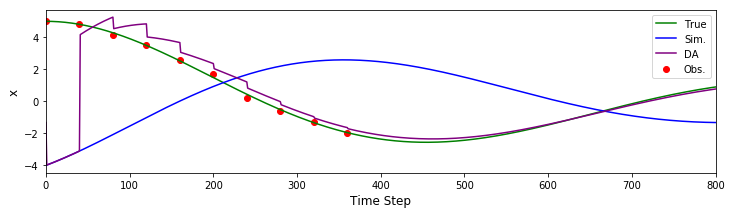

RMSE of Simulation =  3.92370528628
RMSE of DA result =  1.95694175015


In [4]:
vis = Visualization.Visualization(xobs, xtrue, xsim, xda, obs_interval, nt_asm,'x', 800)
vis.fit()
vis.rmse()

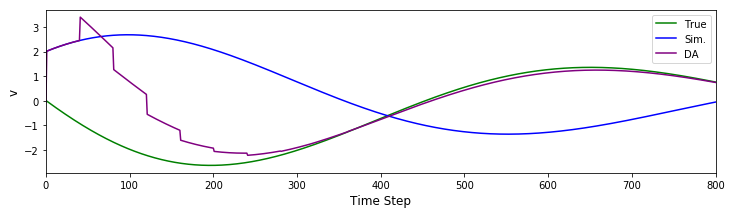

RMSE of Simulation =  2.95531004459
RMSE of DA result =  1.33289527436


In [5]:
vis = Visualization.Visualization(None, vtrue, vsim, vda, obs_interval, nt_asm,'v', 800)
vis.fit()
vis.rmse()